# About the dataset

<ul>
    <li>This dataset belongs to Trip Advisor hotels, where customer review texts and customer review ratings are collected </li>
    <li>20491 reviews with ratings</li>
    <li>Rating in 1 to 5</li>
    <li>Rating 1 to 3 is considered as bad (labeled as 0)</li>
    <li>Rating 4 to 5 is considered as good (labeled as 1)</li>
</ul>

# Objective

<ul>
    <li>Train an NLP model with the given data </li>
    <li>Predict the rating based on unseen review text</li>
</ul>

# Acknowledgements

$\textbf{Citation: }$ Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic sentiment: modeling semantic aspects for online reviews. Information Sciences 339, 206–223.

$\textbf{Link: }$ https://zenodo.org/records/1219899

# Necessary packages

In [113]:
import pandas as pd

# Exploring the data

In [114]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# Shape of data

The raw data has 20491 number of customer review along with review ratings

In [115]:
df.shape

(20491, 2)

# Check for NaN and duplicate entries

In [116]:
print("Number of duplicate entries : " + str(df.duplicated().sum()))

print("Is there any NaN values?")
df.isna().sum()

Number of duplicate entries : 0
Is there any NaN values?


Review    0
Rating    0
dtype: int64

# Data preprocessing

We will label the ratings in the "Rating" columns as follows:
<ul>
    <li>Rating 1 to 3 is considered as bad (labeled as 0)</li>
    <li>Rating 4 to 5 is considered as good (labeled as 1)</li>
</ul>

In [117]:
def find_rating(rating):
    '''
    The "Rating" column is modified for the further processing
    '''
    if rating == 1 or rating ==2 or rating==3:
        return 0
    else: # for rating 4 and 5
        return 1

df['sentiment'] = df['Rating'].apply(find_rating)

In [118]:
df.head()

,Review,Rating,sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


# Lexicon bases analysis

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool specifically designed for social media texts but also works well on other types of texts. The SentimentIntensityAnalyzer from VADER provides a compound score that represents the overall sentiment of the text.

This approach is valid even if the rating value column is absent

# Data preprocessing

In [119]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [120]:
def preprocess_data(review_text):
    tokenized_data = word_tokenize(review_text.lower())   # sentences are split into words
    filtered_data = []  # removes stop words
    for words in tokenized_data:
        if words not in stopwords.words('english'):
            filtered_data.append(words)
    lemmatized_data = []  ## removes 'ing'or 'ed' at the end of the words
    for words in filtered_data:
        lemmatized_data.append(WordNetLemmatizer().lemmatize(words))
    
    processed_text = " ".join(lemmatized_data)
    return processed_text

### Working demo of the above code

In [121]:
s1 = "Hello, my name is Gourab. I am 28 years old and played football in the past for 5 years...."
print("Raw text : " + s1)
t = word_tokenize(s1.lower())
print("Tokenised text: " + str(t))
f = []
for words in t:
    if words not in stopwords.words('english'):
        f.append(words)
print("After removing stop words: " + str(f))
l = []  
for words in f:
    l.append(WordNetLemmatizer().lemmatize(words))
print("After lemmatizing: " + str(l))
p = " ".join(l)
print("Final: " + p)

Raw text : Hello, my name is Gourab. I am 28 years old and played football in the past for 5 years....
Tokenised text: ['hello', ',', 'my', 'name', 'is', 'gourab', '.', 'i', 'am', '28', 'years', 'old', 'and', 'played', 'football', 'in', 'the', 'past', 'for', '5', 'years', '....']
After removing stop words: ['hello', ',', 'name', 'gourab', '.', '28', 'years', 'old', 'played', 'football', 'past', '5', 'years', '....']
After lemmatizing: ['hello', ',', 'name', 'gourab', '.', '28', 'year', 'old', 'played', 'football', 'past', '5', 'year', '....']
Final: hello , name gourab . 28 year old played football past 5 year ....


# Preprocessing the Review text

In [122]:
df['Review'] = df['Review'].apply(preprocess_data)

# Finding the model sentiment

In [123]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [127]:
def get_model_sentiment(review_text):
    sentiment_scores = SentimentIntensityAnalyzer().polarity_scores(review_text)
    if(sentiment_scores['compound']<=0):
        return 0
    if(sentiment_scores['compound']>0):
        return 1

df['vader_sentiment'] = df['Review'].apply(get_model_sentiment)
df.head()

,Review,Rating,sentiment,vader_sentiment
0,nice hotel expensive parking got good deal sta...,4,1,1
1,ok nothing special charge diamond member hilto...,2,0,1
2,nice room 4 * experience hotel monaco seattle ...,3,0,1
3,"unique , great stay , wonderful time hotel mon...",5,1,1
4,"great stay great stay , went seahawk game awes...",5,1,1


# Evaluation of VADER sentiment analysis

In [129]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [130]:
print(classification_report(df['sentiment'], df['vader_sentiment']))

              precision    recall  f1-score   support

           0       0.95      0.20      0.33      5398
           1       0.78      1.00      0.87     15093

    accuracy                           0.79     20491
   macro avg       0.86      0.60      0.60     20491
weighted avg       0.82      0.79      0.73     20491



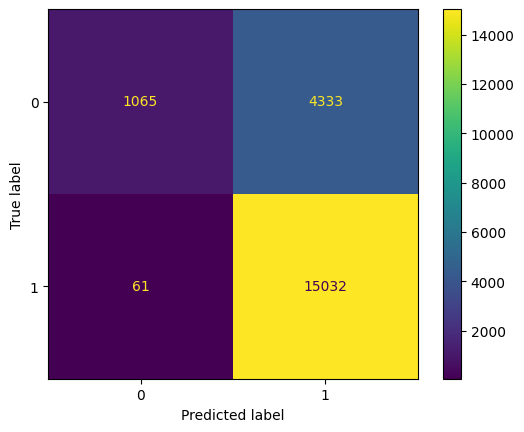

In [131]:
cm =confusion_matrix(df['sentiment'], df['vader_sentiment'])
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# ML based approach --> TF-IDF Transformation

For this algorithm, we will clean the data by removing punctuations, special characters and digits as they do not make much sense here

In [133]:
from sklearn.feature_extraction.text import re
# re stands for regular expression

In [135]:
def clean_data(review_text):
    no_punc = re.sub(r'[^\w\s]', '', review_text)

    no_digit = ''
    for char in no_punc:
        if not char.isdigit():
            no_digit += char
    return no_digit

### Explanation of the cleaning function

<ul>
    <li>The re.sub substitutes the matching expression with blank string (as given in the argument)</li>
    <li>r'[...]' indicates it accepts the backslash (\) character as it is and not as an escape character</li>
    <li>[...] this is the expression that the re function tries to match</li>
    <li>^ indicates negetion</li>
    <li>\w is the representation of word characters as well as underscore: a-zA-Z0-9_</li>
    <li>\s indicates whitespace chars, spaces and newline chars</li>
    <li>no_punc = re.sub(r'[^\w\s]', '', review_text) creates a no_punc array where the re function tries to find the matching chars which are not in the r'[^\w\s]'</li>
    <li>The no_digit is an array that removes any digit and replace and join it with '' blank</li>
</ul>

### Working demo for clean_data function

In [136]:
print(clean_data("Hello, my name is Gourab. I am 28 years old"))
print(clean_data("Very nice hotel!! Rooms are clear, neat. I am giving 5 star * for this...."))

Hello my name is Gourab I am  years old
Very nice hotel Rooms are clear neat I am giving  star  for this


# TF-IDF Transformation

Now, we need to convert this text data into a numeric representation so that it can be ingested into the ML model. We will do this with the help of scikit-learn’s TF-IDF Vectorizer package.

TF-IDF stands for “term frequency-inverse document frequency” – a statistical measure that tells us how relevant a word is to a document in a collection. In simpler terms, it converts words into a vector of numbers where each word has its own numeric representation.

### Term Frequency (TF)

It’s really what it says on the tin – how many times a term is repeated in a single document. Words that appear more frequently in a piece of text are considered to have a lot of importance.

For example, in a job description, if the keywords "NLP" appeares multiple times, then an ML model will consider this highly relevant

### Inverse Document Frequency (IDF)

Rather than focusing on individual pieces, inverse document frequency measures how many times a word is repeated across a set of documents. And opposite of the previous metric, here the higher frequency is – the lower the relevance. This helps the algorithm eliminate naturally occurring words such as “a”, “the”, “and”, etc, as they will appear frequently across all documents in a corpus

In [137]:
from  sklearn.feature_extraction.text import TfidfVectorizer

In [139]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

### Working demo of TFIDF

In [143]:
document = ["This is a sample document.", "This document is another example."]
tfidf_matrix = tfidf.fit_transform(document)
print(tfidf_matrix.toarray())

[[0.44832087 0.         0.44832087 0.         0.44832087 0.63009934]
 [0.37930349 0.53309782 0.37930349 0.53309782 0.37930349 0.        ]]


# Go back to our review dataset

In [144]:
df_ML = df.copy()
df_ML = df_ML.drop(columns=["vader_sentiment"])

In [146]:
df_ML.head()

,Review,Rating,sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice room 4 * experience hotel monaco seattle ...,3,0
3,"unique , great stay , wonderful time hotel mon...",5,1
4,"great stay great stay , went seahawk game awes...",5,1


In [147]:
X = tfidf.fit_transform(df['Review'])

We will perform various ML models for prediction

In [151]:
from sklearn.model_selection import train_test_split
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# ML model 1 --> Logistic regression

In [157]:
from sklearn.linear_model import LogisticRegression

Origin: liblinear is a library for large linear classification. It was specifically designed for linear classification problems like logistic regression and linear support vector machines (SVMs).

Optimization Algorithm: liblinear uses the coordinate descent algorithm, which optimizes the objective function by updating one parameter at a time, holding the others fixed. This can be efficient for certain types of problems, particularly those with small to medium-sized datasets.

Regularization: liblinear supports L1 and L2 regularization. Regularization helps prevent overfitting by adding a penalty to the model's complexity.

Binary Classification: liblinear is well-suited for binary classification problems but can also handle multi-class classification using a one-vs-rest scheme.

In [156]:
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
pred_LR = clf.predict(X_test)

# Model evaluation

In [158]:
print(classification_report(y_test, pred_LR))

              precision    recall  f1-score   support

           0       0.87      0.70      0.78      1044
           1       0.90      0.96      0.93      3055

    accuracy                           0.90      4099
   macro avg       0.89      0.83      0.85      4099
weighted avg       0.90      0.90      0.89      4099



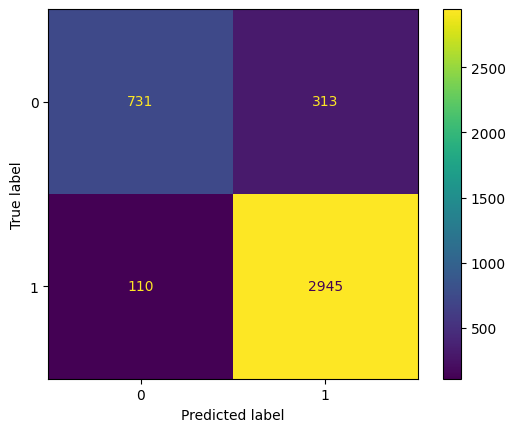

In [159]:
cm =confusion_matrix(y_test, pred_LR)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# ML model 2 --> Gaussian Naive Bayes

 GaussianNB from Scikit-learn is not designed to handle sparse input matrices directly, which is what you typically get when using TfidfVectorizer. On the other hand, LogisticRegression can handle sparse matrices.

Use X_test = X_test.toarray() to make dense data, but this example is running out of memory in this case

# ML model 3 --> Decision Tree Classifier

In [165]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [166]:
%%time

dt = DecisionTreeClassifier()
tree_params = {
    'max_depth' : [2,3,4,5,6,7],
    'min_samples_split' : [2,3,4,5],
    'min_samples_leaf' : [1,2,3,4]
}

scoring = {
    'accuracy' : 'accuracy',
    'precision' : 'precision',
    'recall' : 'recall',
    'f1' : 'f1'
}

cv_instance = GridSearchCV(dt, tree_params, scoring=scoring, cv=5, refit='f1').fit(X_train, y_train)

CPU times: total: 10min 4s
Wall time: 10min 12s


# Save Grid search result in pickle file

In [167]:
import pickle

# Dump the Gridsearch CV result as a pickle file

with open("dt_model.pk", 'wb') as file:
    pickle.dump(cv_instance, file)

# read the model from pickle file

with open("dt_model.pk", 'rb') as file:
    cv_tree_loaded = pickle.load(file)

## Optimized parameter for Decision Tree

In [168]:
cv_tree_loaded.best_params_

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 4}

In [169]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=4).fit(X_train, y_train)
pred_DT = dt.predict(X_test)

# Model evaluation

In [170]:
print(classification_report(y_test, pred_DT))

              precision    recall  f1-score   support

           0       0.73      0.20      0.32      1044
           1       0.78      0.97      0.87      3055

    accuracy                           0.78      4099
   macro avg       0.75      0.59      0.59      4099
weighted avg       0.77      0.78      0.73      4099



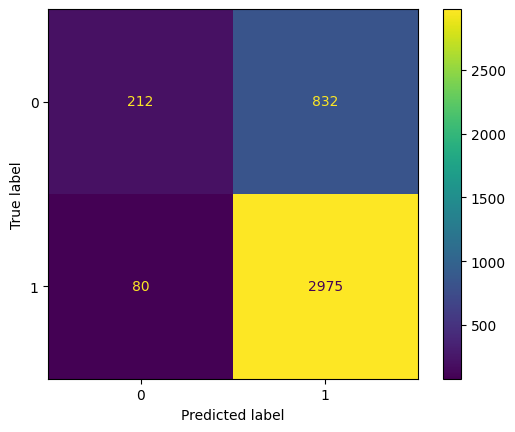

In [171]:
cm =confusion_matrix(y_test, pred_DT)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()